# Using CLIP with VQGan for Image Generation

In [34]:
import torch
from torchvision import transforms
import torch.nn.functional as F
import imitools as I

In [2]:
device = "cuda"
I.defaults.device = device

In [3]:
# #getting CLIP
# !git clone https://github.com/openai/CLIPfrom_pretrained

In [4]:
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning

In [5]:
from CLIP import clip # The clip model
clip_model = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)

## Finding Similarity

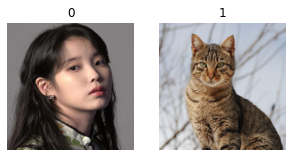

In [50]:
im_iu = I.load("images/iu.png").resize(224)
im_cat = I.load("images/cat.png").resize(224)

I.load([im_iu, im_cat]).show()

In [13]:
# a text embedding
clip_model.encode_text(clip.tokenize("Cat").to(device)).shape

torch.Size([1, 512])

In [20]:
# a image embedding
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
clip_model.encode_image(normalize(im_iu.resize(224).pt())).shape

torch.Size([1, 512])

In [21]:
def get_text_embs(text):
    return clip_model.encode_text(clip.tokenize(text).to(device))

def get_image_embs(image):
    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
    return clip_model.encode_image(normalize(image.pt()))

## Finding Similarity

In [35]:
# this is how we do it
get_similarity = torch.nn.CosineSimilarity()

In [32]:
# for cat
cat_image_embs = get_image_embs(im_cat)
get_similarity(cat_image_embs, get_text_embs("Cat")).item(), get_similarity(cat_image_embs, get_text_embs("Human")).item()

(0.265380859375, 0.2216796875)

In [33]:
iu_image_embs = get_image_embs(im_iu)
get_similarity(iu_image_embs, get_text_embs("Cat")).item(), get_similarity(iu_image_embs, get_text_embs("Human")).item()

(0.1971435546875, 0.209228515625)

**See. That's the way how we can find the captions for an image via CLIP**

In [36]:
# Let's use a different tool
# here lower values has a better match
def clip_loss(im_embed, text_embed):
    im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
    text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
    dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
    return dists.mean()

In [38]:
clip_loss(cat_image_embs, get_text_embs("Cat")).item(), clip_loss(cat_image_embs, get_text_embs("Human")).item()

(0.84716796875, 0.908203125)

In [48]:
clip_loss(iu_image_embs, get_text_embs("Cat")).item(), clip_loss(iu_image_embs, get_text_embs("Human")).item()

(0.94287109375, 0.92529296875)

**It works well in that case too.**